In [1]:
require 'torch'
require 'nn'
require 'image'
-- debug = false

-- arg = '-i ./images/mnist/last_mnist_adversarial_0_7_6.png -cuda'

-- cmd = torch.CmdLine()
-- cmd:text('Adversarial network generation')
-- cmd:text()
-- cmd:text('Options')
-- cmd:option('-i', 'none', 'Input image file')
-- cmd:option('-g', 'false', 'Greyscale input')
-- cmd:option('-o', './images/mnist/transform/', 'Output directory')
-- cmd:option('-cuda', false,'CUDA support')
-- cmd:option('-gpu', 1,'GPU device number')
-- cmd:option('-seed',123,'Random seed')
-- cmd:text()
-- params = cmd:parse(arg)

#### Set parameters

In [2]:
path = './images/mnist/gen/'
greyscale = false
outPath = './images/mnist/transform/'
cuda = true
deviceNum = 1
seed = 123
threads = 4
mnist = true
transform = true
torch.manualSeed(seed)
torch.setdefaulttensortype('torch.FloatTensor')
torch.setnumthreads(threads)

if cuda then
    require 'cutorch'
    require 'cunn'
    cutorch.setDevice(deviceNum)
end

### Analyzing Perturbations in adversarial images

Currently Working:
Generate images.
Display images that Tricked network
Plot the feature maps in layer X

Need to Implement:
H

Whole effing purpose?
Not sure.

### Image loading functions

Functions to get images in the generated images folder, filter by tag, and load

In [3]:
-- http://stackoverflow.com/questions/9676113/lua-os-execute-return-value
function GetFiles(mask)
   local files = {}
   local tmpfile = '/tmp/stmp.txt'
   os.execute('ls -1 '..mask..' > '..tmpfile)
   local f = io.open(tmpfile)
   if not f then return files end  
   local k = 1
   for line in f:lines() do
      files[k] = line
      k = k + 1
   end
   f:close()
   return files
 end

-- Retrieve files from list matching a certain pattern string_#_#_[any_seed].png
function filterFiles(files, target)
    local code = target .. '_%d+.png'
    local filtered = {}
    local k = 1
    for key, name in pairs(files) do
        if string.find(name, code) then
--             if debug == true then
--                 print(name)
--             end
            filtered[k] = name
            k = k+1
        end            
    end  
    return filtered
end
    

function getImages(files)
    local path = 'images/mnist/gen/'
    local adversarial = {}
    local distortion = {}
    local original= {}
    local i = 1
    local j = 1
    local k = 1
    for key, name in pairs(files) do
        local fname = path .. name
--         if debug == true then
--             print(fname)
--         end
        local size = image.getSize(fname)
        if string.find(name, 'adversarial') then
            adversarial[i] = image.load(fname, size[1],'byte')
            i = i + 1            
        elseif string.find(name, 'distortion') then
            distortion[j] = image.load(fname, size[1],'byte')
            j = j + 1            
        elseif string.find(name, 'original') then
            original[k] = image.load(fname, size[1],'byte')
            k = k + 1
        else
            print("Error reading image filename.")
        end
    end
    return adversarial, distortion, original   
end

##### Load Images

Testing file
Found 4 samples	
True Label: #9	
Adversarial Prediction: #1	


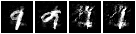

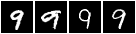

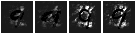

In [153]:
--For sample adversarial image
-- Choose the origin and target classes for the images

-- Note that the most from and to files are different
local files = GetFiles('images/mnist/gen')
local from = '9'
local to = '1'
local code = from .. '_' .. to
local filtered = filterFiles(files, code)
adv, distort, orig = getImages(filtered)


--Strip labels from filename
i, j = 0, 0
i, j = code:find('[0-9]+')
true_label = code:sub(i, j)
i, j = code:find('[0-9]+', j+1)
adv_label = code:sub(i, j)
-- i, j = code:find('[0-9]+', j+1)
-- seed = code:sub(i, j)

io.write("Testing file\n")
local n = #filtered / 3
print("Found ".. n .. " samples" )
print("True Label: #" .. true_label)
print("Adversarial Prediction: #" .. adv_label)
itorch.image(adv)
itorch.image(orig)
itorch.image(distort)

#### Set path and dataset

In [5]:
package.path = package.path .. ';./mnist/?.lua;./overfeat/?.lua;./lbfgsb/?.lua;./'

if mnist then
    print("Using MNIST")
	require 'mnist_model'
	mnist = require 'mnist_utils'
else
    print("Using ImageNet")
	require 'overfeat'
end

Using MNIST	


## Measurement Functions

##### makePrediction 
    - allows the current model to predict a label for an inputed image
##### showResults
    - Prints out whether the prediction was correct, adversarial (i.e. spoofed label), or a different one.
##### displayImage() 
    - Scales an image to 500, 500 so that it is visible
###### scaled
    - wrapper for scaling images
###### diffmontage 
    - Plots the activations of feature maps at input of adversarial, original, and the difference between the two

In [169]:
makePrediction = function(net, x)
    if cuda then
        return torch.max(net:forward(x):float(), 1)
    else 
        return torch.max(net:forward(x), 1)
    end
end

showResults = function(xform, param, img1, adv_label, true_label)--prob, idx)
    local prob
    local idx
    prob, idx = makePrediction(net, img1)
    local guess = label[idx:squeeze()]
    local validity
    local result
    if tonumber(true_label) == tonumber(guess) then
        result = 0
    elseif tonumber(guess) == tonumber(adv_label) then
        result = 1
    else
        result = -1
    end
    io.write(guess,",",adv_label,",", true_label,",", xform,"\n") -- with prob - ",
--     print(prob)
         -- prob:squeeze() .. "\n")
    return result
end


displayImage = function(x, y)
    itorch.image(image.scale(x, y, y, 'simple'))
end

-- Wrapper for scaling
scaled = function(x, y)
    return image.scale(x, y, y, 'simple')
end

montage = function(layer, img)
    if cuda then
        local imgCuda = img:cuda():reshape(mnist.n)
        net:forward(imgCuda)
    else
        net:forward(img)
    end
    n = net.modules[layer].output:size()[1]
    stack = {}
    for i = 1, n do
        map = image.scale(net.modules[layer].output[i]:double(), 100, 100, 'simple')
        table.insert(stack, map)
    end
    -- stack.insert{nrow=32}
    itorch.image(stack)
end


diffmontage = function(layer, img1, img2, display)
    local img1Cuda
    local img2Cuda
    if cuda then
        img1Cuda = img1:cuda():reshape(mnist.n)
        img2Cuda = img2:cuda():reshape(mnist.n)
        net:forward(img1Cuda)
    else
        net:forward(img1)
    end
    
    
    local n = net.modules[layer].output:size()[1]
    local stack1 = {}
    local stack2 = {}
    local stackdiff= {}
    for i = 1, n do
        table.insert(stackdiff, net.modules[layer].output[i]:double())
        map = image.scale(net.modules[layer].output[i]:double(), 100, 100, 'simple')
        table.insert(stack1, map)
    end    
    if cuda then
        net:forward(img2Cuda)
    else
        net:forward(img2)
    end
    
    for i = 1, n do
        stackdiff[i] = image.scale(stackdiff[i] - net.modules[layer].output[i]:double(), 100, 100, 'simple')
        map = image.scale(net.modules[layer].output[i]:double(), 100, 100, 'simple')
        table.insert(stack2, map)
    end
    -- stack.insert{nrow=32}
    if display == true then
        io.write("Adversarial Maps.\n")
        itorch.image(stack1)
        io.write("Original Maps.\n")
        itorch.image(stack2)
        io.write("Difference Img1 - Img2.\n")
        itorch.image(stackdiff)
    --     print(stackdiff[1])
    end
    return stackdiff
end

function pca(x, n_comp, whitened)
    -- Center data
    local mean = torch.mean(x, 1)
    local x_m = x - torch.ger(torch.ones(x:size(1)), mean:squeeze())

    -- Calculate Covariance
    local cov = x_m * x_m:t()
    --  cov:div(x:size(1) - 1)

    -- Get eigenvalues and eigenvectors
    local ce, cv = torch.symeig(cov, 'V')
    -- Sort eigenvalues
    local ce, idx = torch.sort(ce, true)
    
    -- Sort eigenvectors
    cv = cv:index(2, idx:long())

    -- Keep only the top
--     if n_comp and n_comp < cv:size(2) then
--         ce = ce:sub(1, n_comp)
--         cv = cv:sub(1, -1, 1, n_comp)
--     end

    -- Check if whitened version
    -- vectors are divided by the singular values to ensure uncorrelated outputs with unit component-wise variances.
    if not whitened then
        ce:add(1e-5):sqrt()
    end

    -- Get inverse
    local inv_ce = ce:clone():pow(-1)

    -- Make it a matrix with diagonal inv_ce
    local inv_diag = torch.diag(inv_ce)
    
    -- Transform to get U
    local u = x_m:t() * cv * inv_diag

    return u
end

#### Testing that adversarial imges fool the network

In [170]:
function check(img1, fname,  adv_label, true_label)
    local toTest = img1
    if cuda then toTest = toTest:cuda():reshape(mnist.n) end
    --Get label
    local result = showResults("None: ", 0, toTest, adv_label, true_label)
    if result == 0 then
        io.write("Error: image", fname ,"classified correctly.\n")
--     else 
--         print("Image spoofs model. Conducting tests")
    end
end

##### Check for the initial predictions of each of the adversarial images (may not be what is expected)

In [171]:
for key, im in pairs(adv) do
    check(im, key, adv_label, true_label)
end

 0
[torch.FloatTensor of size 1]

 2
[torch.LongTensor of size 1]

1,1,9,None: 


 0
[torch.FloatTensor of size 1]

 5
[torch.LongTensor of size 1]

4,1,9,None: 
 0
[torch.FloatTensor of size 1]

 2
[torch.LongTensor of size 1]

1,1,9,None: 


 0
[torch.FloatTensor of size 1]

 2
[torch.LongTensor of size 1]

1,1,9,None: 


In [9]:
--Wrapper to conveniently compare lists
function displayLists(adv, orig)
    diffs = {}
    for i=1,#adv, 1 do
        check(adv[i], i, adv_label, true_label)
        print("Montage " .. i)
        displayImage(adv[i], 500)
--         montage(3, adv[i])
        diffs[i] = diffmontage(3, adv[i], orig[i], true)
    end
    thing = diffs[1]
--     print(thing)
    for i = 1, #diffs, 1 do    
        for j = 1, #diffs[i] do
            thing[j] = thing[j] + diffs[i][j]
        end
    end
    itorch.image(thing)
end

### Map Feature Map back onto original image space

- select a specific neuron whose activations you wish to map back to the original image space

#### mapBack
- Returns the image on the input space of a specific input

#### projectDiffs
- Wrapper function to compare the projections of two different inputs (i.e. the adversarial and original images

#### montageProjections
- Wrapper function to go through each input in parallel tables and call projectDiffs. Returns a table of difference images

#### mapLayer
- Wrapper that iterates through all neurons in a layer and sums the projections on the input space

In [10]:
function mapBack(net, layer, neuron, img)
    local testNet = net:clone()
    local levWeights = testNet.modules[layer].weight:clone()
    
    --Send forward
    testNet:zeroGradParameters()
    local output = testNet:forward(img:cuda())
    for i=1, (#levWeights:squeeze())[1], 1 do
        if i ~= neuron then
            testNet.modules[layer].weight[i] = 0.0
        else
            testNet.modules[layer].weight[i] = 1.0
        end
    end
    --send backward
    local gradInput = testNet:backward(img:cuda(), output)
    return(gradInput:double())
end


function projectDiffs(net, layer, neuron, img1, img2)
    local proj1 = mapBack(net, layer, neuron, img1)
    local proj2 = mapBack(net, layer, neuron, img2)
    return proj2 - proj1
end

function montage_projections(net, layer, neuron, adv, orig)
    local differences = {}
    for i=1, #adv, 1 do
        differences[i] = projectDiffs(net, layer, neuron, adv[i], orig[i])
--         displayImage(differences[i], 200)        
    end
    return differences
end

### Average the difference in activations over a specific layer

#### mapLayer
- displays the total difference in projections over all neurons in a layer over all images in the adversarial and original image sets

#### montageSingleProjections
- returns the projections onto the input space of a given image over all neurons in a layer

#### mapOverImages
- returns average over all neurons in a layer over all images in parallel tables

In [11]:
function mapLayer(net, layer, adv, orig, displayAll)
    local size = #adv
    local largeSum = torch.DoubleTensor(#net.modules[2].output):zero() -- hardcode reshaped data in
    for i=1, (#net.modules[layer].weight)[1] do
        local differences = montage_projections(net, layer, i, adv, orig)
        local sum = torch.DoubleTensor(#differences[1]):zero()
        for j = 1,#differences do
            sum = sum + differences[j]
        end    
        largeSum = largeSum + sum
        if displayAll then
            displayImage(sum, 100)
        end
    end
    displayImage(largeSum, 500)
end

function montageSingleProjections(net, layer, img, displayAll)
    local projs = {}
    for i=1, (#net.modules[layer].weight)[1], 1 do
        local proj = mapBack(net, layer, i, img)
        local proj = proj - torch.min(proj) -- make positive, starting at 0
        local max = torch.max(proj) 
        if max > 0.001 then
            proj = proj/ max -- Unit size
        end
        if displayAll == true then
--             print(displayAll)
            displayImage(proj, 100)
        end
        projs[i] = proj
    end
    return projs
end
-- display the resuls fro
function mapOverImages(net, layer, imgs, displayAll, displaySums)
--     local projs = {}
    local largeSum = torch.DoubleTensor(#net.modules[2].output):zero()
    for i=1, #imgs do
        local projs =  montageSingleProjections(net, layer, imgs[i], displayAll)   
        local sum = torch.DoubleTensor(#projs[1]):zero()
        for j=1, #projs do
            sum = sum + projs[j]
        end
        sum = sum / #projs
        largeSum = largeSum + sum
        if displaySums == true then
--             print(displayAll)
--             print(sum)
            displayImage(sum, 200)
        end 
    end
    largeSum = largeSum --/ torch.max(largeSum)
    displayImage(largeSum, 500)
    return largeSum
end

### Display the inputed images (adversarial and original)

In [157]:
-- for i=1, #adv do
--    displayImage(adv[i], 100) 
--    displayImage(orig[i], 100)
--    displayImage(distort[i], 100)
-- end

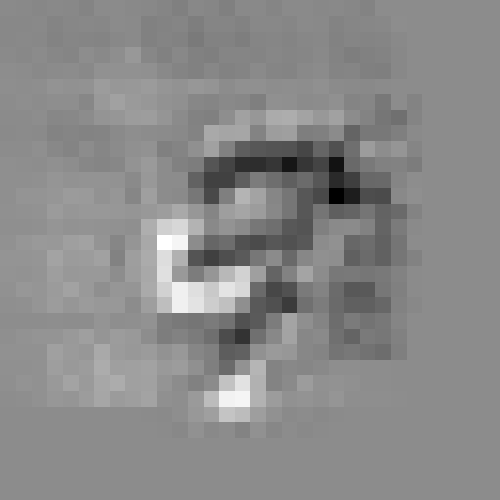

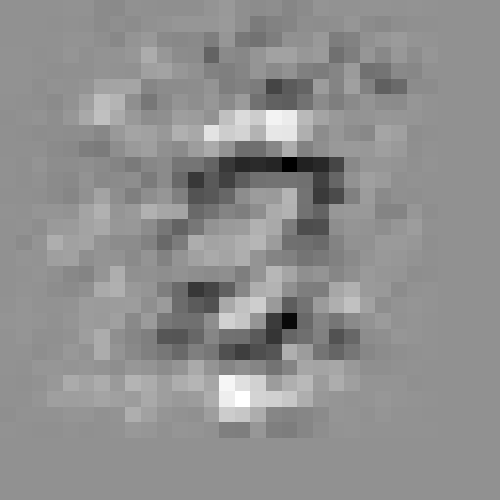

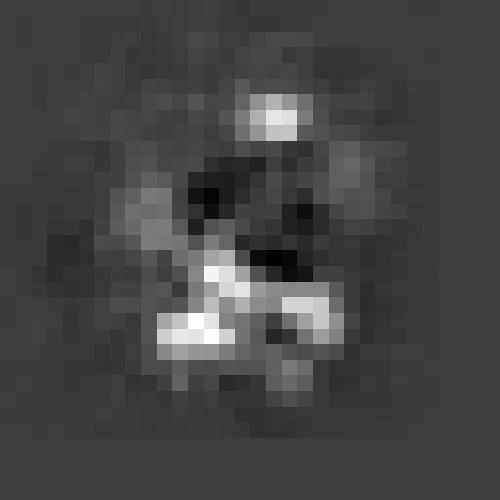

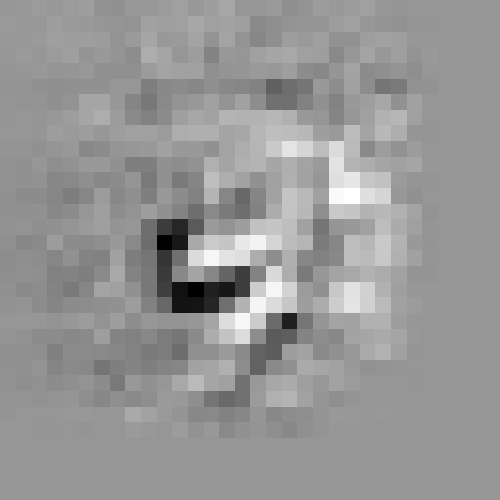

In [13]:
local sum = mapOverImages(net, 6, orig, false, false)
local sum2 = mapOverImages(net, 6, adv, false, false)
local sum3 = mapOverImages(net, 10, distort, false, false)
-- print(torch.max(sum))
-- print(torch.min(sum))
-- print(torch.max(sum2))
-- print(torch.min(sum2))
sum = sum / torch.max(torch.abs(sum))
sum = sum + torch.min(sum)
sum2 = sum2 / torch.max(torch.abs(sum2))
sum2 = sum2 + torch.min(sum2)
displayImage(sum2 - sum, 500)
-- print(sum)

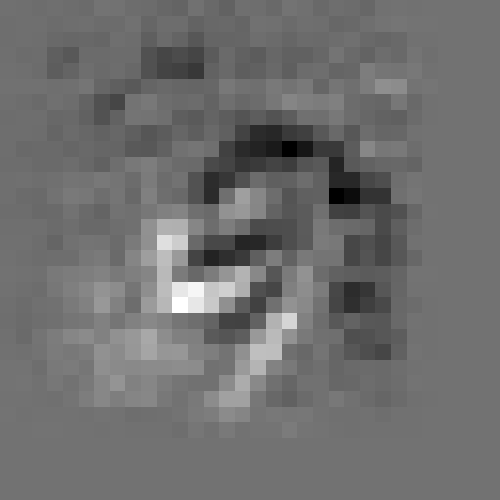

In [14]:
mapLayer(net, 6, adv, orig, True)

### Module ___ Return the norm of the activations over a given layer for a given input

** Note that this won't really work for negative activations...

In [228]:
-- Returns a sorted table of neurons and activity differences.
compareActivities = function(net, layer, img1, img2, display)
    local img1Cuda
    local img2Cuda
    if cuda then
        img1Cuda = img1:cuda():reshape(mnist.n)
        img2Cuda = img2:cuda():reshape(mnist.n)
        net:forward(img1Cuda)
    else
        net:forward(img1)
    end
    
    local n = net.modules[layer].output:size()[1]
    local stack1 = {}
    local stack2 = {}
    local stackdiff= {}
    local output = torch.Tensor(#net.modules[layer].output[1]):zero()
    
    for i = 1, n do
        output = net.modules[layer].output[i]:double()
        table.insert(stackdiff, output)
        map = image.scale(output, 100, 100, 'simple')
        table.insert(stack1, map)
    end    
    if cuda then
        net:forward(img2Cuda)
    else
        net:forward(img2)
    end
    
    for i = 1, n do
        output = net.modules[layer].output[i]:double()
        stackdiff[i] = image.scale(stackdiff[i] - output, 100, 100, 'simple')
        map = image.scale(output, 100, 100, 'simple')
        table.insert(stack2, map)
    end
    -- stack.insert{nrow=32}
    if dispay == true then
        io.write("Adversarial Maps.\n")
        itorch.image(stack1)
        io.write("Original Maps.\n")
        itorch.image(stack2)
        io.write("Difference Img1 - Img2.\n")
        itorch.image(stackdiff)
    --     print(stackdiff[1])
    end
    
    for i=1,n do
        stackdiff[i] = torch.norm(stackdiff[i])
        if display == true then
            print(stackdiff[i])
        end
    end
    
    local a = {}
    
    for i, n in pairs(stackdiff) do
        table.insert(a, torch.Tensor({i, n}))
    end

    table.sort(a,function(a,b) return a[2]>b[2] end)
    return a
end

function chooseK(table, k, inverse, values)
    local a = {}
    local ind = 1
    if values == true then
        ind = 2
    end
    if inverse == true then
        for i = k, #table do
            a[i - k+1] = table[i][ind]
        end
    else
        for i = 1, k do
            a[i] = table[i][ind]
        end
        
    end
    return a    
end


-- Train 
function trainHardNegatives(net, layer, neuronsOff, img, true_label, labels)
    local testNet = net:clone() -- TODO eliminate in the final
    local levWeights = testNet.modules[layer].weight:clone()
    
--     print("Hello world")
    -- Zero out low error neurons
    for i=1, #neuronsOff do
        local ind = neuronsOff[i]
--         print(ind)
        testNet.modules[layer].weight[ind] = 0.0
    end
    
    --Send forward
    testNet:zeroGradParameters()
    local x = img:cuda():reshape(mnist.n)
    local output = net:forward(x)
    -- Get Predictions
    local prob, idx = torch.max(output, 1)
    local prediction = labels[idx:squeeze()]

    local gradInput = testNet:backward(img:cuda(), output)

    
    -- Reinsert weights for those NOT activated.
    for i=1, #neuronsOff do
        local ind = neuronsOff[i]
        testNet.modules[layer].weight[ind] = levWeights[ind]
    end
    
    return net -- testNet    
end

Test Functions

Prediction = 1	
 0
[torch.CudaTensor of size 1]

-606.5800
   0.0000
-582.4445
-218.0117
 -40.3092
-678.6051
-731.0300
-118.5953
-145.3941
-120.9737
[torch.CudaTensor of size 10]



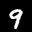

In [233]:
local k = 10
local layer = 6
local activitiesList = compareActivities(net, 6, adv[1], orig[1], false)
local filteredList = chooseK(activitiesList, k, true, false)
-- print(filteredList)
trainHardNegatives(net, layer, filteredList, adv[1], '9', label)
itorch.image(orig[1])

In [176]:
-- print(label)
local prob, idx = makePrediction(net, orig[1]:cuda():reshape(mnist.n))
print(prob)
print(idx)
print(idx:squeeze())
local guess = label[idx:squeeze()]
print(guess)

 0
[torch.FloatTensor of size 1]

 10
[torch.LongTensor of size 1]

10	
9	


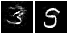

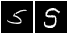

In [95]:
-- Note that the most from and to files are different
local files = GetFiles('images/mnist/gen')
local from = '5'
local to = '3'
local code = from .. '_' .. to
local filtered = filterFiles(files, code)
adv2, distort2, orig2 = getImages(filtered)
itorch.image(adv2)
itorch.image(orig2)

In [ ]:
-- print((#net.modules[6].gradInput:squeeze())[1])
-- for i=1, (#net.modules[6].gradInput:squeeze())[1] do
--     itorch.image(net.modules[6].gradInput:squeeze()[i])
-- end

-- local i = 1
-- local output = net:forward(adv[i]:cuda())
-- net:zeroGradParameters()
-- local gradInput = net:backward(adv[i]:cuda(), output)
-- displayImage(adv[i])
-- displayImage(gradInput:double())
-- output = net:forward(adv[i]:cuda())
-- gradInput = net:backward(adv[i]:cuda(), output)
-- displayImage(gradInput:double())
-- -- displayImage(adv[2])

In [ ]:
mapBack(net, 6, 10, orig[1], adv[1])

In [ ]:
net.modules[6].weight

In [ ]:
testNet.modules[6].weight[{{2,64}}] = 0.0

In [ ]:
torch.mean(img:double(), 1)

In [ ]:
torch.ger(torch.ones(img:size()), torch.mean(img:float(), 1):squeeze())

In [ ]:
project = testNet:backward(toTest, outTest):reshape(32, 32)

In [ ]:
function pca(x)
   x = x:squeeze()
   local mean = torch.mean(x,1)
   local xm = x - mean:expandAs(x)
   xm:div(math.sqrt(x:size(1)-1))
   local w,s,v = torch.svd(xm:t())
   s:cmul(s)
   return s,w
end

In [ ]:
s, w = pca(img_original:double())

In [ ]:
w = w[{{1, 32},{5,32}}]

In [ ]:
print(#w)

In [ ]:
itorch.image(image.scale(img:squeeze():float() * w:float() * w:float():t(), 150, 150, 'simple'))
itorch.image(image.scale(img_original:squeeze():float() * w:float() * w:float():t(), 150, 150, 'simple'))

In [ ]:
itorch.image(image.scale(img_original:squeeze(), 150, 150, 'simple'))

In [ ]:
itorch.image(image.scale(img_original:squeeze():double():cmul(w):cmul(w:t()), 150, 150, 'simple'))

In [ ]:
itorch.image(image.scale(project:float(), 150, 150, 'simple'))

### Need to add a function to VISUALIZE a given convolutional layer

I.e. given a particular input, display the activations of layers vis a vis the original.

-- -- Rotate to +/- 45 degrees using simple interpolation
-- print('Rotating image')
-- for i = -45, 45, 5 do
-- 	local imgRot = image.rotate(img, i * math.pi/180, mode)
-- 	local toTest = imgRot
-- 	if cuda then toTest = toTest:cuda():reshape(mnist.n) end
-- 	--Get label
-- 	local prob, idx = makePrediction(toTest)
-- 	local result = showResults("Rotate", i, prob, idx)
-- 	if result == -1 then
--         displayImage(imgRot)
--         montage(3)
-- 		image.save(outPath .. save_name .. '_rotated_' .. 'strange_' .. i .. '.png', imgRot)
-- 	elseif result == 0 then
-- 		image.save(outPath .. save_name .. '_rotated_' .. 'correct_' .. i .. '.png', imgRot)
-- 	end
-- end

-- --Random noise
-- print('Adding Random Gaussian noise')
-- for i = 0, 255, 5 do
-- 	local r = (torch.rand(size[2], size[3]) * i - (i/2)):floor()
-- 	-- print(r)
-- 	local imgNoise = img:float():add(r)
-- 	-- print(imgNoise)
-- 	local min = imgNoise:min()
-- 	local max = imgNoise:max()
-- 	--Renormalize values in [0, 255)
-- 	imgNoise = imgNoise:add(-min):div((max-min)/255.0):floor():byte()
-- 	local toTest = imgNoise
-- 	if cuda then toTest = toTest:cuda():reshape(mnist.n) end
-- 	--Get label
-- 	local prob, idx = makePrediction(toTest)
-- 	local result = showResults("Random Noise", i, prob, idx)
-- 	if result == -1 then
-- 		image.save(outPath .. save_name .. '_rand_noise_' .. 'strange_' .. i .. '.png', imgNoise)
-- 	elseif result == 0 then
-- 		image.save(outPath .. save_name .. '_rand_noise_' .. 'correct_' .. i .. '.png', imgNoise)
-- 	end
-- end

-- --Try a negative image
-- print('Negative Scaled Image')
-- local toTest = -img + 255
-- local norm = toTest:clone()
-- if cuda then toTest = toTest:cuda():reshape(mnist.n) end
-- --Get label
-- local prob, idx = makePrediction(toTest)
-- local result = showResults("Negative Image", -1, prob, idx)
-- if result == -1 then
-- 	image.save(outPath .. save_name .. '_negative_' .. 'strange_' .. i .. '.png', norm)
-- elseif result == 0 then
-- 	image.save(outPath .. save_name .. '_negative_' .. 'correct_' .. i .. '.png', norm)
-- end

-- --Subtract adverserial mean from the adv image
-- print('Subtracting the mean of the adversarial spoofed label')

-- for i = 0, 0.5, 0.025 do 
-- 	local toTest = img:float():add(-i*mnist.means[adv_label+1])
-- 	--Renormalize
-- 	local min = toTest:min()
-- 	local max = toTest:max()
-- 	--Renormalize values in [0, 255)
-- 	toTest = toTest:add(-min):div((max-min)/255.0):floor():byte()
-- 	local norm = toTest:clone()
-- 	if cuda then toTest = toTest:cuda():reshape(mnist.n) end
-- 	--Get label
-- 	local prob, idx = makePrediction(toTest)
-- 	local result = showResults("Subtract Adv Mean", i, prob, idx)
-- 	if result == -1 then
--         montage(3)
-- 		image.save(outPath .. save_name .. '_sub_adv_mean_' .. 'strange_' .. i .. '.png', norm)
-- 	elseif result == 0 then
--         montage(3)
-- 		image.save(outPath .. save_name .. '_sub_adv_mean_' .. 'correct_' .. i .. '.png', norm)
-- 	end

-- end

-- --Apply a gaussian filter
-- print('Try adding gaussian blur')
-- local kern = image.gaussian()
-- print(kern)
-- toTest = img:float()
-- toTest = image.convolve(toTest, kern, 'same'):byte()
-- local norm = toTest:clone()
-- if cuda then toTest = toTest:cuda():reshape(mnist.n) end
-- --Get label
-- local prob, idx = makePrediction(toTest)
-- local result = showResults("Gaussian Blur", i, prob, idx)
-- if result == -1 then
-- 	image.save(outPath .. save_name .. '_gaussian_' .. 'strange_' .. i .. '.png', norm)
-- elseif result == 0 then
-- 	image.save(outPath .. save_name .. '_gaussian_' .. 'correct_' .. i .. '.png', norm)
-- end

-- --Apply a Laplacian filter
-- print('Try adding laplacian filter')
-- local kern = image.laplacian(3, 0.25, 1, true)
-- toTest = norm:float()
-- toTest = image.convolve(toTest, kern, 'same'):byte()
-- local norm = toTest:clone()
-- if cuda then toTest = toTest:cuda():reshape(mnist.n) end
-- --Get label
-- local prob, idx = makePrediction(toTest)
-- local result = showResults("Laplacian Blur", i, prob, idx)

if result == -1 then
	image.save(outPath .. save_name .. '_laplacian_' .. 'strange_' .. i .. '.png', norm)
elseif result == 0 then
	image.save(outPath .. save_name .. '_laplacian_' .. 'correct_' .. i .. '.png', norm)
end